# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2:</center>
### <center> Propiedades en Venta </center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing as skp

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from collections import defaultdict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


Descargo los datos para el modelo 1

In [2]:
_x_train_model1 = pd.read_csv('./DataSet/x_train')
_x_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1 = pd.read_csv('./DataSet/y_train')
_y_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_x_test_model1 = pd.read_csv('./DataSet/x_test')
_x_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_test_model1 = pd.read_csv('./DataSet/y_test')
_y_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1.rename(columns={'0':'pxm2'}, inplace=True)
_y_test_model1.rename(columns={'0':'pxm2'}, inplace=True)

# 3. Ensamble de modelos

Construir dos ensambles de modelos de tipo híbridos :

* Ensamble 1: ensamble tipo Voting para el conjunto de datos de clasificación.
Obtener sus métricas y comparar los resultados con los obtenidos en los puntos
anteriores.

* Ensamble 2: ensamble de tipo Stacking combinando diferentes modelos de
regresión y utilizando un modelo adicional para estimar el valor final. Mostrar las
métricas obtenidas y comparar con los resultados obtenidos en los puntos
anteriores.

### Ensamble 1: Vooting


El clasificador de votaciones tiene dos hiperparámetros básicos: estimadores y votaciones. 

El hiperparámetro estimators crea una lista los clasificadores y les asigna nombres. 

El hiperparámetro de votación se establece en "hard" o "soft".

* hard: el clasificador de votación usa las etiquetas de clase predichas para la votación por regla de la mayoría. 

* soft: utilizará un enfoque ponderado para tomar su decisión (predice la etiqueta de clase en función del argmax de las sumas de las probabilidades predichas)

In [3]:
#Ejecutare mis modelos con una copia
x_train = _x_train_model1.copy()
y_train = _y_train_model1.copy()
x_test = _x_test_model1.copy()
y_test = _y_test_model1.copy()

In [4]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [5]:
#Creo clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42,probability=True)
knn_clf = KNeighborsClassifier()
arbol_clf=  DecisionTreeClassifier(random_state = 42)

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('svm', svm_clf), 
                                         ('knn', knn_clf), 
                                         ('arbol', arbol_clf)], 
                                        voting = 'soft')




#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

0.75

In [6]:
# Visualizamos algunas metricas para cada modelo por separado

list_of_classifiers = [svm_clf, knn_clf, arbol_clf, vot_clf]
# Loop scores
for classifier in list_of_classifiers:
    classifier.fit(x_train,y_train)
    pred = classifier.predict(x_test)

    print("F1 Score:")
    print(classifier.__class__.__name__, f1_score(y_test, pred))
    print("Accuracy:")
    print(classifier.__class__.__name__, accuracy_score(y_test, pred))
    print("----------")

F1 Score:
SVC 0.7763864042933811
Accuracy:
SVC 0.7916666666666666
----------
F1 Score:
KNeighborsClassifier 0.7832167832167832
Accuracy:
KNeighborsClassifier 0.7933333333333333
----------
F1 Score:
DecisionTreeClassifier 0.6282722513089005
Accuracy:
DecisionTreeClassifier 0.645
----------
F1 Score:
VotingClassifier 0.7377622377622378
Accuracy:
VotingClassifier 0.75
----------


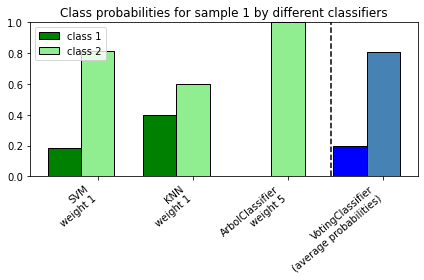

In [7]:
# predict class probabilities for all classifiers
probas = [classifier.fit(x_train, y_train).predict_proba(x_train) for classifier in (list_of_classifiers)]
    
#----------------------------------------------------------------------------------------------    
    
    # get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['SVM\nweight 1',
                    'KNN\nweight 1',
                    'ArbolClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.show()

# Ensamble 2: Stacking

In [8]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_regression(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           random_state= None)

In [9]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

Para obtener un nivel de referencia de performance y poder compararlo con el ensamble, entrenaremos y evaluaremos individualmente los siguientes modelos base:

* K- vecinos mas cercanos
* Arbol de decisión
* XGBoost

Por otro lado el modelo adicional para estimar el valor final será
* Bosque aleatorio con 50 árboles de decisión (RF).

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que se almacenarán en un diccionario.

In [10]:
#Armo conjunto entrenamiento y test 80-20
#Ejecutare mis modelos con una copia
x_train = _x_train_model1.copy()
y_train = _y_train_model1.copy()
x_test = _x_test_model1.copy()
y_test = _y_test_model1.copy()


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)

In [11]:
#Modelos Base
base_models = {'knn':KNeighborsRegressor(),
               'arbol': DecisionTreeRegressor(),
               'xgbRegressor': xgb.XGBRegressor(random_state = 0)
              }

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los regresores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating knn


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating arbol
Evaluating xgbRegressor


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished


In [12]:
from sklearn.ensemble import StackingRegressor

#Modelos Base
base_models = [('knn', KNeighborsRegressor()),
               ('arbol', DecisionTreeRegressor()),
               ('xgbRegressor', xgb.XGBRegressor(random_state = 0))]

#Meta Modelo
meta_model = RandomForestRegressor()

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [13]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   18.6s finished


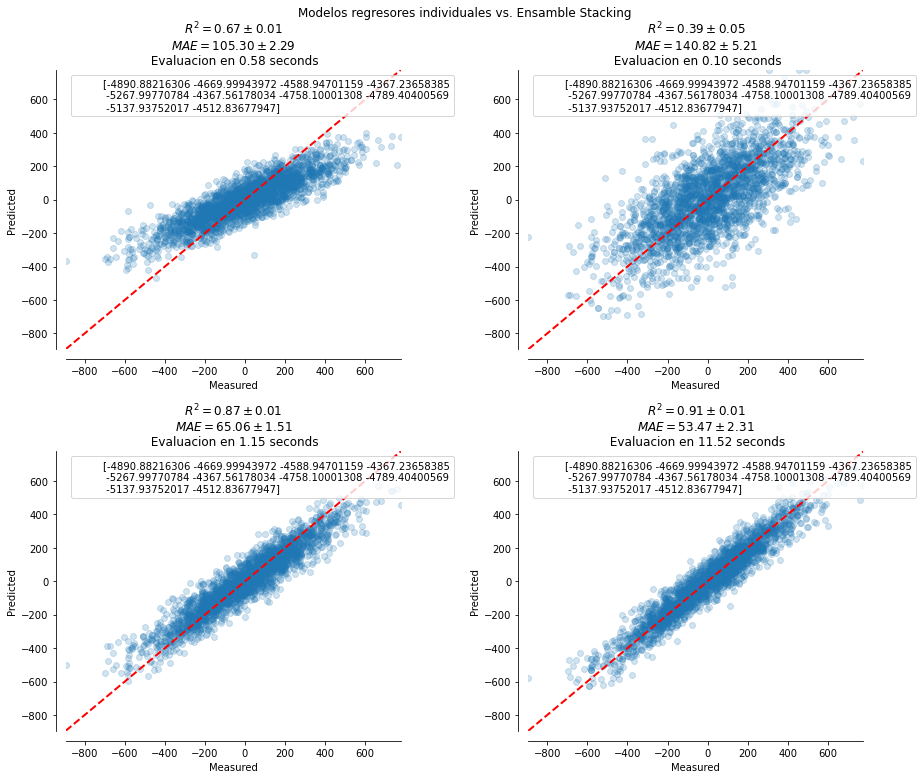

In [14]:
import time
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_test, y_pred_st, title, stacking_scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2)
    ax.scatter(y_test, y_pred_st, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_test.min(), y_test.max()])
    ax.set_ylim([y_test.min(), y_test.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=8
    )
    ax.legend([extra], [stacking_scores], loc="upper left")
    title = title + "\n Evaluacion en {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(13, 11))
axs = np.ravel(axs)

for ax, (name, stacking_model) in zip(
    axs, base_models + [("Stacking Regressor", stacking_model)]
):
    start_time = time.time()
    score = cross_validate(stacking_model, x_train, y_train, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred_st = cross_val_predict(stacking_model, x_train, y_train, n_jobs=2, verbose=0)

    plot_regression_results(ax, y_train,y_pred_st,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),stacking_scores,elapsed_time)

plt.suptitle("Modelos regresores individuales vs. Ensamble Stacking")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [15]:
#Evaluo en conjunto de test
from sklearn.metrics import mean_absolute_error
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
mean_absolute_error(y_test, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


51.67529535688494